In [1]:
import sys
import numpy as np
import copy
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import csv
from sklearn.cluster import KMeans

# BIRCH (Balanced Iterative Reducing and Clustering using Hierarchies)

BIRCH is an algorithm designed for the incremental clustering of large datasets with metric attributes.<br>
Its efficiency relies on a data structure called the **CF Tree** (Clustering Feature Tree),
which represents clusters in a compact and hierarchical way.

The CF Tree is a balanced tree structure. It is employed by BIRCH to maintain a "summary" of the clusters in memory instead of all the datapoints.
**The tree structure and its construction are the core of the algorithm**.

### Clustering Features
Each node of the tree contains a list of **Clustering Feature (CF)**, that is, compact structures that summarize a subset of points from the dataset.
A Clustering Feature is defined as a triple:
- **N**: number of points
- **LS (Linear Sum)**: sum of the vectors of the points, $\vec{LS} = \sum_{i=1}^{N} \vec{x}_i$

- **SS (Square Sum)**: sum of the squared norms of the points, $\text{SS} = \sum_{i=1}^{N} \|\vec{x}_i\|^2$

These quantities allow the computation of the centroid, radius, and diameter of each cluster. In fact:
- The **centroid** of the cluster is $\vec{C} = \frac{1}{N} \sum_{i=1}^{N} \vec{x}_i = \frac{\vec{LS}}{N}$

- The **radius**, which represents the measure of dispersion of the points with respect to the centroid, is $R = \sqrt{ \frac{1}{N} \sum_{i=1}^{N} \left( \vec{x}_i - \vec{C} \right)^2 }  = \sqrt{ \frac{SS}{N} - \left( \frac{\vec{LS}}{N} \right)^2 }$
- The **diameter**, which represents the average maximum distance between the points of the cluster, is $D = \sqrt{\frac{1}{N(N - 1)} \sum_{i=1}^{N} \sum_{j = 1}^{N} \left( \vec{x_i} - \vec{x_j} \right)^2} = \sqrt{\frac{2N \cdot SS - 2  \|\vec{LS}\|^2}{N(N-1)}}$

Thanks to this representation, a cluster can be thought of as a set of points, but stored only through the CF vector as a "summary".<br>
Moreover, it is efficient because it allows fast updates when merging two clusters: it is enough to sum the two corresponding CF vectors thanks to the additivity theorem:
Let $\text{CF}_1 = (N_1, \vec{LS}_1, SS_1)$ and $\text{CF}_2 = (N_2, \vec{LS}_2, SS_2)$ be the CF vectors of two disjoint clusters.<br>
Then, the CF vector of the cluster obtained by merging the two disjoint clusters is:
$\text{CF}_1 + \text{CF}_2 = \left( N_1 + N_2, \vec{LS}_1 + \vec{LS}_2, SS_1 + SS_2 \right)$.

The Clustering Feature is not only efficient because it stores much less than all the data points of the cluster, but it is also accurate because it is sufficient to compute all the measures needed to make clustering decisions in BIRCH.

In [2]:
class ClusteringFeature:
	def __init__(self, data_dimensionality):
		self.N = 0
		self.LS = np.zeros(data_dimensionality)
		self.SS = 0

	def add_point(self, x):
		self.N += 1
		self.LS += np.array(x)
		self.SS += np.dot(x, x)
		return self

	def merge(self, other: 'ClusteringFeature'):
		self.N += other.N
		self.LS += other.LS
		self.SS += other.SS
		return self

	def centroid(self):
		if self.N == 0:
			return np.zeros_like(self.LS)
		return self.LS / self.N

	def radius(self):
		centroid = self.centroid()
		variance = (self.SS / self.N) - np.dot(centroid, centroid)
		# Evita numeri negativi 
		variance = max(variance, 0)  
		return float(np.sqrt(variance))

	def diameter(self):
		if self.N <= 1:
			return 0.0
		numerator = 2 * self.N * np.sum(self.SS) - 2 * np.dot(self.LS, self.LS)
		denominator = self.N * (self.N - 1)
		diameter_sq = numerator / denominator
		return np.sqrt(diameter_sq)

	def dist(self, other: 'ClusteringFeature') -> float:
		# Euclidean distance between the centroids of two ClusteringFeature
		return float(np.linalg.norm(self.centroid() - other.centroid()))

	def __repr__(self):
		return f"ClusteringFeature(N={self.N}, LS={self.LS}, SS={self.SS:.4f})"

	def __copy__(self):
		copied = ClusteringFeature(np.size(self.LS, 0))
		copied.merge(self)
		return copied

	def __eq__(self, value: object) -> bool:
		if value is not None and isinstance(value, ClusteringFeature):
			return self.N == value.N and all(self.LS == value.LS) and self.SS == value.SS
		return False

	def __sizeof__(self) -> int:
		to_return = 0
		for element in (self.N, self.LS, self.SS):
			to_return += sys.getsizeof(element)
		return to_return


### CF Tree

A CF tree is a height-balanced tree with two parameters:
- **branching factor B** 
- **threshold T**.<br>

Each node of the tree contains a list of CFs (at most B), and each CF contains a pointer to its (unique) parent node and to its (unique) child node.

Thus, B is the maximum number of children per internal node, i.e., the maximum number of CFs that can be stored in a node.

T is the maximum radius of a cluster, or absorption factor. It determines the maximum allowed distance between a datapoint and the centroid of a cluster for that point to be included in the cluster.<br>
It helps control the compactness of the clusters.

#### Datapoint Insertion Algorithm
1. Search for the appropriate leaf to insert `Ent`.
	- Start from the root of the tree.
	- At each level, find the CF of the parent node closest to `Ent` and move to the corresponding child node. For the concept of "closeness," use the Euclidean distance between the CF centroid and `Ent`.
	- Continue descending the tree following a CF path until reaching a leaf node.
2. Identify the closest CF in the leaf
	- Within the found leaf node, compute the distance between `Ent` and each CF present in the leaf.
	- Select the closest CF as a candidate to absorb `Ent`.
3. Attempt to insert `Ent` into the leaf
	- If the selected CF can absorb `Ent` without the radius (or diameter) exceeding the threshold `T`:
		* `Ent` is added to the CF, updating its parameters `(N, LS, SS)`.
	- If the CF cannot absorb `Ent`, evaluate the leaf capacity:
		* If the leaf has space (i.e., the number of CFs is < `B`):
			* Create a new CF for `Ent` and add it to the leaf.
		* If the leaf is full:
			* `Ent` is temporarily inserted as a new CF in the leaf.
			* The leaf is splitted:
				- Identify the two most distant CFs within the leaf: they will be the seeds of two new leaf nodes.
				- Assign the remaining CFs to the closest seed.
				- The leaf becomes an internal node with two new children.
				- If the parent has space, update its CF list.
				- If the parent has no space, repeat the split recursively upwards.
				- If the root is split, the tree grows in height (a new root is created).
4. Update the path
	- After insertion, update the CFs along the path from the leaf to the root to reflect the addition of the new point (update the aggregated CFs in internal nodes).
5. Refinement to optimize the structure (Merging Refinement)
	- If a parent node has children that were just split and still has available space:
		- Scan the CFs present in the node.
		- Find the two closest CFs (not both from the previous split).
		- Evaluate the possibility of merging the two CFs:
		- Merge their child lists under one of the two CFs.
		- Remove the other CF from the parent node, freeing space.
		- If the resulting CF has too many child lists (exceeds `B`):
			- Perform a local split to balance the distribution.

##### Observations
A datapoint is always and only inserted into a leaf node, not into internal nodes.<br>
The datapoint can be represented as a CF.<br>
This algorithm must be executed for all points to be inserted.

In [3]:
class CFTree:
	def __init__(self, data_dimensionality, branching_factor, threshold, is_leaf: bool, parent=None):
		self.branching_factor = branching_factor
		self.threshold = threshold
		self.is_leaf = is_leaf
		self.data_dimensionality = data_dimensionality
		self.parent = parent
		self.CF_list: list[ClusteringFeature] = []
		# List of children (only if it is not a leaf)
		self.children_list: list['CFTree'] = []

	def insert_CF(self, cf: ClusteringFeature, outlier=False) -> bool:
		# If leaf node
		if self.is_leaf:
			# If the leaf node is still empty (no CFs)
			if not self.CF_list:
				self.CF_list.append(cf)
				return True

			# I try to check if the closest one and the input one are < T
			# 'closest_cf' is a CF, the closest to the CF passed as input
			closest = self.find_closest_CF(cf)
			closest_cf = self.CF_list[closest]
			temp_cf = copy.copy(closest_cf)
			temp_cf.merge(cf)

			if temp_cf.radius() < self.threshold:
				# Yes case, we are good to go, add
				closest_cf.merge(cf)
				return True
			elif not outlier:
				# Otherwise, add the CF to the node
				self.CF_list.append(cf)
				return True
		# If NOT leaf node
		else:
			closest = self.find_closest_CF(cf)
			# Through the index, find the child node
			child = self.children_list[closest]

			# Insert CF in child node, aka call this method recursively
			to_return = child.insert_CF(cf)

			if len(child.CF_list) > self.branching_factor:
				seed1, seed2 = self.split_child(closest)
				if len(self.children_list) <= self.branching_factor:
					# Merging refinement
					self.merge_refinement(seed1, seed2)
			else:
				# Update cumulative CF in the child node
				self.CF_list[closest] = self.children_list[closest].compute_cumulative_CF()
			return to_return
		return False

	def _find_index(self, mode="furthest"):
		# Find the index of the pair of CFs that are farthest or closest
		op = 1.0 if mode == "furthest" else -1.0
		seed1 = 0
		seed2 = 0
		max_dist = -float("inf")
		for i in range(len(self.CF_list)-1):
			for j in range(i + 1, len(self.CF_list)):
				dist = op * self.CF_list[i].dist(self.CF_list[j])
				if dist > max_dist:
					max_dist = dist
					seed1 = i
					seed2 = j
		return seed1, seed2

	def split_child(self, idx: int) -> tuple[int, int]:
		# Perform the split of the child at index `idx` in the current node
		child = self.children_list[idx]
		# Find the farthest nodes
		seed1, seed2 = child._find_index(mode="furthest")

		# Create two new nodes
		params_dict = {"data_dimensionality": self.data_dimensionality,
					   "branching_factor": self.branching_factor,
					   "threshold": self.threshold,
					   "is_leaf": child.is_leaf,
					   "parent": self
					   }
		new_node1 = CFTree(**params_dict)
		new_node2 = CFTree(**params_dict)
		# Insert the two seeds into the new nodes
		new_node1.CF_list.append(child.CF_list[seed1])
		new_node2.CF_list.append(child.CF_list[seed2])
		if not child.is_leaf:
			# then they have children
			new_node1.children_list.append(child.children_list[seed1])
			new_node2.children_list.append(child.children_list[seed2])

		# Insert the remaining CFs
		for node_idx, cf in enumerate(child.CF_list):
			if node_idx not in (seed2, seed1):
				dist1 = cf.dist(new_node1.CF_list[0])
				dist2 = cf.dist(new_node2.CF_list[0])
				if dist1 < dist2:
					# Insert in the new tree
					new_node1.CF_list.append(cf)
					if not child.is_leaf:
						# Then has children and insert them
						new_node1.children_list.append(
							child.children_list[node_idx])
				else:
					new_node2.CF_list.append(cf)
					if not child.is_leaf:
						new_node2.children_list.append(
							child.children_list[node_idx])
		# Add the two new nodes as children of the current node
		self.children_list.append(new_node1)
		self.CF_list.append(new_node1.compute_cumulative_CF())
		self.children_list.append(new_node2)
		self.CF_list.append(new_node2.compute_cumulative_CF())
		# Remove the original child node
		self.CF_list.pop(idx)
		self.children_list.pop(idx)
		# Correct the indices if necessary
		if seed1 > idx:
			seed1 -= 1
		if seed2 > idx:
			seed2 -= 1
		return seed1, seed2

	def find_closest_CF(self, cf: ClusteringFeature) -> int:
		# Find the index of the closest CF based on the centroid
		min_dist = float('inf')
		closest = 0
		for idx, node in enumerate(self.CF_list):
			dist = np.linalg.norm(node.centroid() - cf.centroid())
			if dist < min_dist:
				min_dist = dist
				closest = idx
		return closest

	def compute_cumulative_CF(self):
		# Calculate the aggregated ClusteringFeature of the node
		cf = ClusteringFeature(self.data_dimensionality)
		for entry in self.CF_list:
			cf.merge(entry)
		return cf

	def _find_smallest_increase(self) -> float:
		# Calculate the minimum distance between pairs to estimate density
		if self.is_leaf:
			# Find the closest ones
			seed1, seed2 = self._find_index("smallest")
			dist = self.CF_list[seed1].dist(self.CF_list[seed2])
			# Returns their distance
			return dist
		# Else, find the densest child
		idx_max = np.argmax(list(map(lambda x: x.N, self.CF_list)))
		return self.children_list[idx_max]._find_smallest_increase()

	def merge_refinement(self, split1, split2):
		# Step 1: find the two closest CFs
		seed1, seed2 = self._find_index("closest")
		# If they are not both split1 and split2
		if split1 != seed1 or split2 != seed2:
			temp_cf = copy.copy(self.CF_list[seed1])
			temp_cf.merge(self.CF_list[seed2])
			# If I can merge them
			if temp_cf.radius() < self.threshold:
				# If they can be merged, transfer all leaves from the second into the first
				for leaf in self.children_list[seed2].leaves():
					self.children_list[seed1].insert_CF(leaf)
				# Clear space
				if seed1 > seed2:
					temp = seed1
					seed1 = seed2
					seed2 = temp
				for idx in sorted((seed1, seed2), reverse=True):
					self.children_list.pop(idx)
					self.CF_list.pop(idx)	
				self.children_list.pop(seed2)
				self.CF_list.pop(seed2)
				# If too large, split
				if len(self.children_list[seed1].children_list) > self.branching_factor:
					self.split_child(seed1)
		return self

	def paths(self, path: list[int] = []):
		# Generate all possible paths to the leaves
		if self.is_leaf:
			yield path
		else:
			for idx, node in enumerate(self.children_list):
				copied = path + [idx]
				yield from node.paths(copied)

	def _avg_nodes_in_leaves(self) -> int:
		# Return the average number of points per leaf
		total_nodes = self.compute_cumulative_CF().N
		leaves_number = 0
		for leaf in self.leaves():
			leaves_number += 1
		return total_nodes // leaves_number

	def leaves(self):
		# Return all CFs from the leaves
		if self.is_leaf:
			for cf in self.CF_list:
				yield cf
		else:
			for child in self.children_list:
				yield from child.leaves()

	def __getitem__(self, path):
		current_node = self
		for node in path:
			current_node = current_node.children_list[node]
		return current_node

	def __repr__(self, level=0) -> str:
		to_return = ""
		indent = "-- " * level
		for idx, node in enumerate(self.CF_list):
			to_return += f"{indent}- {node}\n"
			if self.children_list:
				child = self.children_list[idx]
				to_return += child.__repr__(level + 1)
		return to_return

	def __sizeof__(self) -> int:
		size = object.__sizeof__(self)
		size += sum(sys.getsizeof(cf) for cf in self.CF_list)
		size += sum(child.__sizeof__() for child in self.children_list or [])
		return size


### Example of building the CF Tree on a small dataset
Builds a balanced tree, where each node contains at most `B=2` Clustering Features (based on the radius threshold `T=1.5`).

In [4]:
tree = CFTree(2, 2, 1.5, True)
data = [[3, 4], [2, 6], [4, 5], [4, 7], [3, 8],
        [6, 2], [7, 2], [7, 4], [8, 4], [7, 9]]
for point in data:
    tree.insert_CF(ClusteringFeature(2).add_point(np.array(point)))
    if len(tree.CF_list) > tree.branching_factor:
        new_root = CFTree(tree.data_dimensionality,
                          tree.branching_factor, tree.threshold, False)
        tree.parent = new_root
        new_root.CF_list.append(tree.compute_cumulative_CF())
        new_root.children_list.append(tree)
        new_root.split_child(0)
        tree = new_root
print(tree)

- ClusteringFeature(N=4, LS=[28. 12.], SS=238.0000)
-- - ClusteringFeature(N=4, LS=[28. 12.], SS=238.0000)
-- -- - ClusteringFeature(N=4, LS=[28. 12.], SS=238.0000)
- ClusteringFeature(N=6, LS=[23. 39.], SS=374.0000)
-- - ClusteringFeature(N=1, LS=[7. 9.], SS=130.0000)
-- -- - ClusteringFeature(N=1, LS=[7. 9.], SS=130.0000)
-- - ClusteringFeature(N=5, LS=[16. 30.], SS=244.0000)
-- -- - ClusteringFeature(N=4, LS=[13. 22.], SS=171.0000)
-- -- - ClusteringFeature(N=1, LS=[3. 8.], SS=73.0000)



### BIRCH Algorithm
1. **CF Tree Construction**: data points are inserted one by one into the tree.
2. *(Optional)* **CF Tree Condensation**: aims to extract useful information from the data compressed in the CF Tree to use as a basis for the next step of the algorithm.
3. **Global Clustering**: a classic algorithm (e.g., KMeans) is applied to the micro-clusters.

4. *(Optional and off-line)* **Cluster Refining**: the solution is refined by assigning the original data points to the cluster of the nearest centroid.

In [5]:
class BIRCH:
	def __init__(self, data_dim=2, page_size=512, threshold=0.0, max_size=100_000, estimated_data_size=105_000) -> None:
		self.max_size = max_size
		self.data_dim = data_dim
		self.branching_factor = page_size // sys.getsizeof(ClusteringFeature(data_dim))
		self.threshold = threshold
		self.max_size = max_size
		self.tree = CFTree(self.data_dim, self.branching_factor, self.threshold, True)
		self.old_thresholds: list[list[float]] = [[threshold]]
		self.N_added_list: list[list[int]] = []
		self.radii: list[list[float]] = []
		self.N = estimated_data_size
		self.outlier_threshold = 0
		self.outliers: list[ClusteringFeature] = []
		self.outlier_mem_size = 20 * max_size // 100

	def addall(self, nodefile):
		with open(nodefile, "rt") as f:
			reader = csv.reader(f)
			for row, text in enumerate(reader):
				# Check every 1000 rows that the tree is not too large in MB
				if sys.getsizeof(self.tree) > self.max_size:
					# Re-compute threshold
					threshold = self.recompute_threshold(row)
					# Compress the tree into a smaller one using the new threshold
					self.compress(threshold)
				# Add a node
				coordinates = np.array(text, dtype=float)
				cf = ClusteringFeature(self.data_dim).add_point(coordinates)
				self.tree.insert_CF(cf)
				# Check that the root is not too large
				if len(self.tree.CF_list) > self.branching_factor:
					# Create new root
					new_root = CFTree(
						self.data_dim, self.branching_factor, self.threshold, False)
					self.tree.parent = new_root
					new_root.CF_list.append(self.tree.compute_cumulative_CF())
					new_root.children_list.append(self.tree)
					# Split the old one
					new_root.split_child(0)
					self.tree = new_root
			# Check if the outliers can be absorbed back into the tree, otherwise they are discarded
			to_remove = [self.tree.insert_CF(
				outlier, outlier=True) for outlier in self.outliers]
			self.outliers = [outlier for idx, outlier in enumerate(
				self.outliers) if not to_remove[idx]]
			return self

	def recompute_threshold(self, row: int):
		# Estimate how many data points we want to add in the next iteration
		N_next = min(self.N, 2 * row)
		# Compute the radius of the root
		root = self.tree.compute_cumulative_CF()
		radius = root.radius()
		self.radii.append([radius])
		self.N_added_list.append([row])

		model = LinearRegression()
		# Packed volume V_p = T^d, increases linearly with the threshold
		N_power = [[number[0] ** (1/self.data_dim)] for number in self.N_added_list]
		# Estimate next threshold
		model.fit(N_power, self.old_thresholds)
		next_threshold = model.predict(np.array(N_next).reshape(-1, 1))[0][0]
		# Estimate next radius
		model.fit(self.N_added_list, self.radii)
		radius = model.predict(np.array(N_next).reshape(-1, 1))[0][0]

		expansion_factor = max(1.0, float(radius / self.radii[-1][0]))
		# In the cluster with the most nodes, find the closest leaves
		d_min = self.tree._find_smallest_increase()

		next_threshold = min(d_min, float(expansion_factor * next_threshold))
		# If it is not large enough, increase it
		if next_threshold <= self.old_thresholds[-1][0]:
			next_threshold = next_threshold*(N_next/row)**(1/self.data_dim)
		# Avoid 0.0 as the new threshold
		if next_threshold == 0.0:
			next_threshold = 0.0001
		self.old_thresholds.append([next_threshold])
		return next_threshold

	def compress(self, threshold):
		self.threshold = threshold
		# Threshold to decide if a leaf CF is an outlier
		# Calculate the average number of nodes in the leaves
		self.outlier_threshold = max(self.outlier_threshold, self.tree._avg_nodes_in_leaves() // 4)
		compressed = CFTree(self.data_dim, self.branching_factor, self.threshold, True)
	
		for leaf in self.tree.leaves():
			if leaf.N > self.outlier_threshold:
				compressed.insert_CF(leaf)
			# If this node has less than 20% of the average number of points
			else:
				self.manage_outliers(compressed, leaf)
		self.tree = compressed
		return self

	def manage_outliers(self, compressed: CFTree, leaf: ClusteringFeature):
		# Add to the list of outliers
		self.outliers.append(leaf)
		# If there are too much outliers
		if sys.getsizeof(self.outliers) > self.outlier_mem_size:
			# Reinsert outliers and check which ones were successfully reinserted
			to_remove = [compressed.insert_CF(
				outlier, outlier=True) for outlier in self.outliers]
			# Keep those that were not successfully reinserted
			self.outliers = [outlier for idx, outlier in enumerate(
				self.outliers) if not to_remove[idx]]

### Example on a synthetic dataset of 100K points

In [6]:
# Generate the dataset
X, y = make_blobs(n_samples=100000, centers=10, random_state=42)
# Add some noise
noise = np.random.uniform(low=-10, high=10, size=(5000, 2))
X = np.vstack([X, noise])
with open("data.csv", "tw") as f:
	writer = csv.writer(f)
	writer.writerows(X)

In [7]:
birch = BIRCH()
birch.addall("data.csv")
print(birch.tree)

- ClusteringFeature(N=32594, LS=[-213736.75016505  271808.93779384], SS=4190895.5987)
-- - ClusteringFeature(N=32594, LS=[-213736.75016505  271808.93779384], SS=4190895.5987)
-- -- - ClusteringFeature(N=20598, LS=[-188643.50312761  170359.75913867], SS=3213007.4430)
-- -- -- - ClusteringFeature(N=20598, LS=[-188643.50312761  170359.75913867], SS=3213007.4430)
-- -- -- -- - ClusteringFeature(N=20598, LS=[-188643.50312761  170359.75913867], SS=3213007.4430)
-- -- -- -- -- - ClusteringFeature(N=310, LS=[-2288.3042771    968.62919165], SS=21117.5906)
-- -- -- -- -- -- - ClusteringFeature(N=105, LS=[-930.58649083  228.40507883], SS=8925.6885)
-- -- -- -- -- -- -- - ClusteringFeature(N=105, LS=[-930.58649083  228.40507883], SS=8925.6885)
-- -- -- -- -- -- -- -- - ClusteringFeature(N=57, LS=[-491.61856774   74.37763087], SS=4384.0306)
-- -- -- -- -- -- -- -- -- - ClusteringFeature(N=37, LS=[-331.31218068   43.38260249], SS=3043.9639)
-- -- -- -- -- -- -- -- -- - ClusteringFeature(N=20, LS=[-1

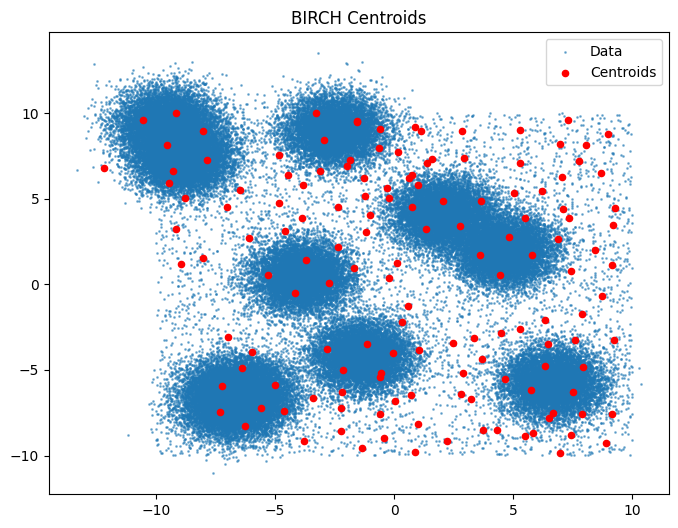

In [8]:
centroids = [leaf.centroid() for leaf in birch.tree.leaves()]
centroids = np.array(centroids)

plt.figure(figsize=(8, 6))
plt.scatter(X[:,0], X[:,1], s=1, alpha=0.5, label="Data")
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=20, label="Centroids")
plt.legend()
plt.title("BIRCH Centroids")
plt.show()

#### Outlier Handling in BIRCH
BIRCH can optionally handle outliers during the construction of the CF Tree. In particular, when the tree is rebuilt (e.g., due to memory limits), some micro-clusters (leaves) with **very low density** can be **considered potential outliers**.

These outliers are:
- **Excluded** from the new CF tree and **stored** in a temporary structure.
- Later, **re-examined** to check if they can be **reabsorbed** with a new threshold or a new distribution.

A micro-cluster is considered an outlier if it contains **far fewer points than the average** of the leaves. At the end of the process, micro-clusters that **cannot be reabsorbed** are considered **true outliers** and may be discarded.

In [9]:
print(birch.compress(birch.threshold).tree)

- ClusteringFeature(N=3696, LS=[-33761.16826262  36994.55293247], SS=682148.4017)
- ClusteringFeature(N=3520, LS=[-37131.47189975  33727.06538602], SS=718111.4173)
- ClusteringFeature(N=4155, LS=[-39527.9352722   33865.86701234], SS=655305.0482)
- ClusteringFeature(N=1618, LS=[-12956.80970071  14514.50733037], SS=234931.4086)
- ClusteringFeature(N=3382, LS=[-26559.76613598  24496.4932855 ], SS=389046.4126)
- ClusteringFeature(N=3824, LS=[-35527.10957037  25238.20773861], SS=500379.5464)
- ClusteringFeature(N=981, LS=[ 745.83066015 4411.1684452 ], SS=21362.9113)
- ClusteringFeature(N=2948, LS=[-4564.21552461 28107.86143916], SS=277750.9742)
- ClusteringFeature(N=2146, LS=[-7011.77658065 21459.22209995], SS=239087.7195)
- ClusteringFeature(N=4365, LS=[-12829.89163183  36832.52931796], SS=352575.5872)
- ClusteringFeature(N=572, LS=[-1067.20403603  4149.67940572], SS=32603.1519)
- ClusteringFeature(N=1937, LS=[ 14584.61879721 -12143.29169868], SS=187109.4682)
- ClusteringFeature(N=1542, LS

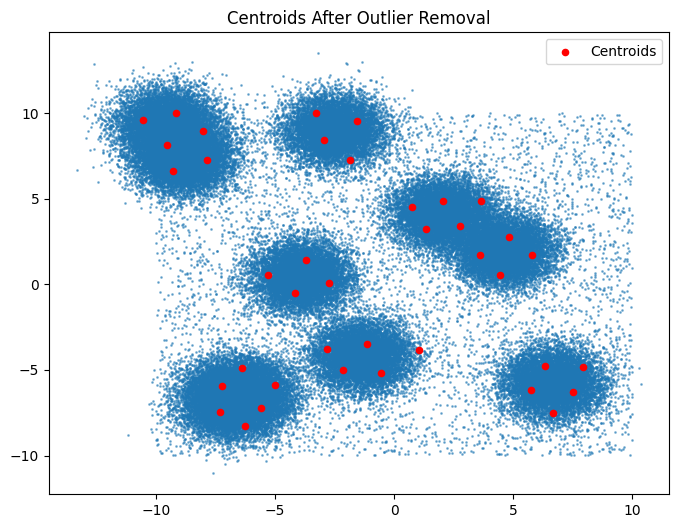

In [10]:
centroids = [leaf.centroid() for leaf in birch.tree.leaves()]
centroids = np.array(centroids)

plt.figure(figsize=(8, 6))
plt.scatter(X[:,0], X[:,1], s=1, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=20, label="Centroids")
plt.legend()
plt.title("Centroids After Outlier Removal")
plt.show()

#### Global Clustering
The final clusters are created by applying a second phase of clustering techniques (I used **K-Means**) to the clusters already formed in the CF tree.
This final step improves overall accuracy and ensures that the resulting clusters are well-separated and representative.

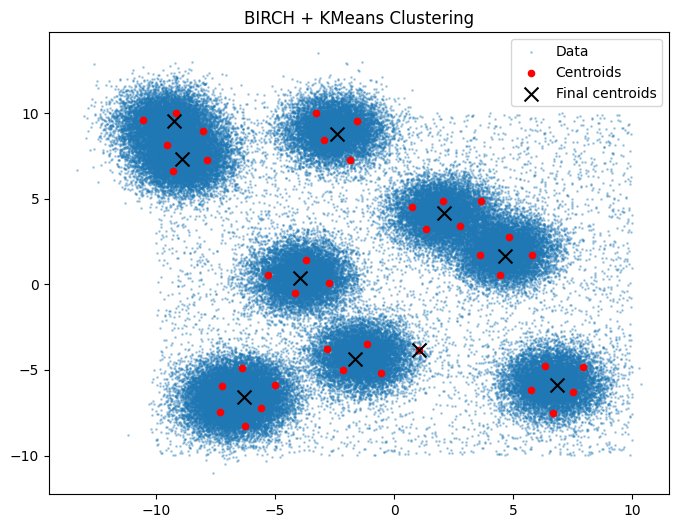

In [11]:
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(centroids)
final_centroids = kmeans.cluster_centers_

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], s=1, alpha=0.3, label="Data")
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=20, label="Centroids")
plt.scatter(final_centroids[:, 0], final_centroids[:, 1], c='black', s=100, marker='x', label="Final centroids")
plt.legend()
plt.title("BIRCH + KMeans Clustering")
plt.show()

### Parameters

##### `page_size`
That is, the size of a memory page. This should fully contain a tree node.

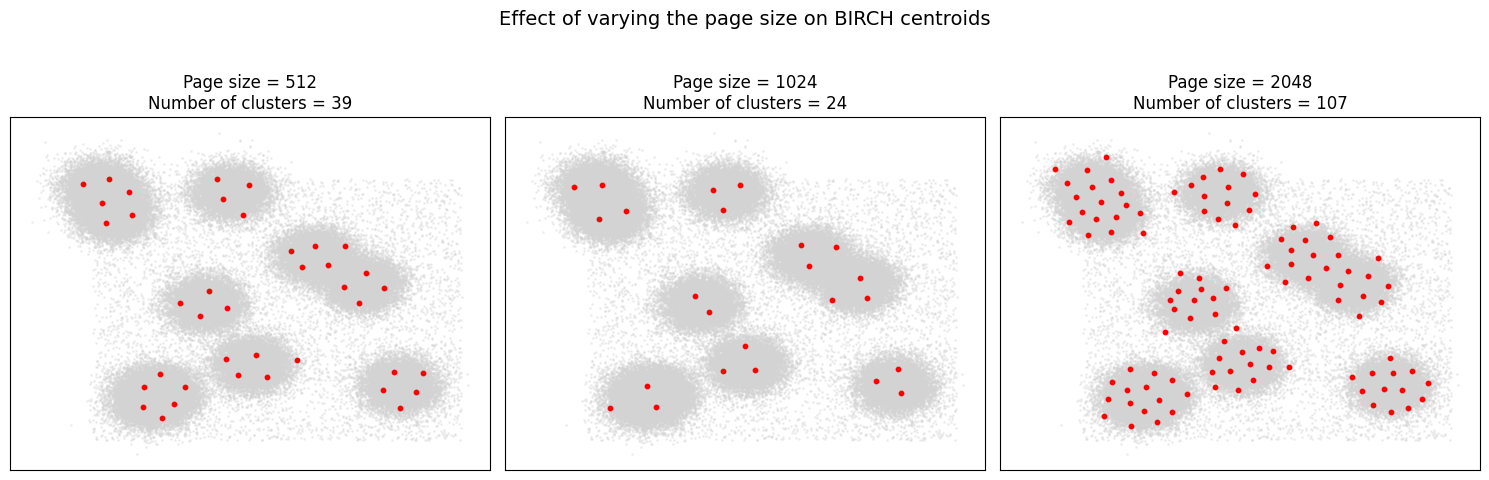

In [12]:
page_sizes = [512, 1024, 2048]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.flatten()

for i, p in enumerate(page_sizes):
	birch_compare = BIRCH(page_size=p)
	birch_compare.addall("data.csv")
	birch_compare.compress(birch_compare.threshold)
	
	centroids_compare = [leaf.centroid() for leaf in birch_compare.tree.leaves()]
	centroids_compare = np.array(centroids_compare)

	ax = axes[i]
	ax.scatter(X[:, 0], X[:, 1], color="lightgray", s=1, alpha=0.3)
	ax.scatter(centroids_compare[:, 0], centroids_compare[:, 1], color="red", s=10)
	ax.set_title(f"Page size = {p}\n"
			  	f"Number of clusters = {len(birch_compare.tree.CF_list)}")
	ax.set_xticks([])
	ax.set_yticks([])

plt.suptitle("Effect of varying the page size on BIRCH centroids", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

##### `max_size`
That is, the maximum number of data points to process before rebuilding the tree.

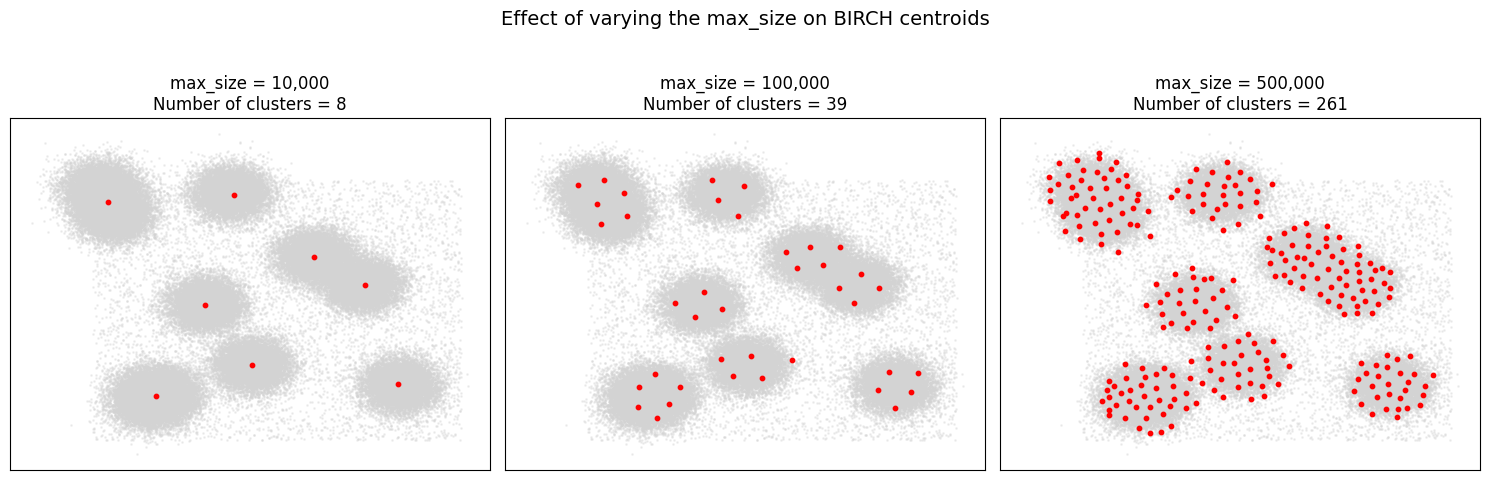

In [13]:
max_sizes = [10_000, 100_000, 500_000]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.flatten()

for i, max_size in enumerate(max_sizes):
    birch_compare = BIRCH(max_size=max_size) 
    birch_compare.addall("data.csv")
    birch_compare.compress(birch_compare.threshold)

    centroids_compare = [leaf.centroid() for leaf in birch_compare.tree.leaves()]
    centroids_compare = np.array(centroids_compare)

    ax = axes[i]
    ax.scatter(X[:, 0], X[:, 1], color="lightgray", s=1, alpha=0.3)
    ax.scatter(centroids_compare[:, 0], centroids_compare[:, 1], color="red", s=10)
    ax.set_title(f"max_size = {max_size:,}\n"
                 f"Number of clusters = {len(birch_compare.tree.CF_list)}")
    ax.set_xticks([])
    ax.set_yticks([])

plt.suptitle("Effect of varying the max_size on BIRCH centroids", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Limitations
BIRCH is an extremely efficient and scalable algorithm for large datasets, but it has some limitations:
- It is sensitive to the order of the data: the CF tree is built incrementally, so the order in which data is read can affect the structure of the micro-clusters.
- It struggles with high-dimensional data.

### Comparison with Other Techniques
In general, BIRCH does not require storing the datapoints in memory, unlike other clustering techniques. In fact, it makes efficient use of the tree structure to process large datasets.

Its cleverness lies in storing and updating a "summary" of the datapoints at each insertion.
* DBSCAN: not sensitive to the order in which data is processed, handles outliers well.